# The Data

The data was shared through the DrivenData website and the Pump-It_Up competition. This is a supervised learning, ternary classification problem based on the status of Tanzanian water-points.  

The focus of the project was to understand which wells, pumps, and water-points might fail or prove to be non-functional. This could help to improve maintenance operations and ensure that clean, potable water is available to the communities of Tanzania. Data was collected by the Tanzanian Ministry of Water and the Taarifa Platform.

The dataset included 59,400 water-points which were labelled as “functioning”, “non-functioning”, or “functioning needs repair”. I decided to stick to the "Pump It Up Competition" rules and treated all the models as having these three classes.  The data was also broken up into three files - "train_set_labels", "train_set_values", and "test_set_values". The third of which I decided were only for submitting to the compettition and I would not include in my model.

## Loading the data and merging files

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
import datetime as dt

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                    GridSearchCV)

from sklearn.metrics import (accuracy_score, 
                            f1_score, 
                            confusion_matrix, 
                            classification_report,
                            confusion_matrix)

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

### Labels

In [2]:
# Load the target labels
target = pd.read_csv("train_set_labels.csv")

In [3]:
# Check out a few of the rows
target.iloc[15:20]

,id,status_group
15,61848,functional
16,48451,non functional
17,58155,non functional
18,34169,functional needs repair
19,18274,functional


In [4]:
# Replace target values - there are three classes
target = target.replace({'status_group': {'functional' : 1, 
                                'non functional' : 0, 
                                'functional needs repair' : 2}})
print(target.shape)

(59400, 2)


In [5]:
# Check to see that it worked
target.iloc[15:20]

,id,status_group
15,61848,1
16,48451,0
17,58155,0
18,34169,2
19,18274,1


### Values

In [6]:
# Load the rest of the data and view
values = pd.read_csv("train_set_values.csv")
values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Merging files

In [7]:
# Merge the target and values into one dataset
df = pd.concat([values, target], axis=1)

# Cleaning

Feature: 'id'

In [8]:
# 'id' feature is the first to be dropped since it is irrelevant
df = df.drop(columns="id", axis=1)

### Missing data

In [9]:
# Check for duplicates
duplicates = df[df.duplicated()]
print(len(duplicates))

36


In [10]:
# Drop all duplicates
df.drop_duplicates(keep='first',inplace=True)

## Clean Continuous Features

In [11]:
# After much debate I decided to start with the continuous features
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
count,59364.000000,59364.000000,59364.000000,5.936400e+04,59364.000000,59364.000000,59364.000000,59364.000000,59364.000000,59364.000000
mean,317.843017,668.702513,34.097560,-5.709463e+00,0.474429,15.295516,5.631494,180.019086,1301.441227,0.688380
std,2998.473133,693.131013,6.517065,2.943608e+00,12.239934,17.592619,9.636138,471.604294,951.369704,0.599883
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.095187,-8.541904e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,370.000000,34.910318,-5.023822e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,1.000000
75%,20.000000,1320.000000,37.179490,-3.326918e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,1.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000


Feature: 'amount_tsh'

In [12]:
# 'amount_tsh' - relates to the amount of water available at the well
print('Data equal to zero:', df.amount_tsh[df['amount_tsh'] == 0].count())
print('Percent of total:', df.amount_tsh[df['amount_tsh'] == 0].count()/len(df))

Data equal to zero: 41603
Percent of total: 0.7008119398962334


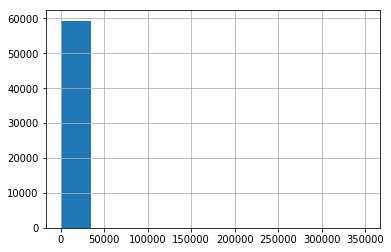

In [13]:
# Most of the values are zero
df.amount_tsh.hist()

In [14]:
# Look for three standard deviations above the mean
amount_tsh_std = df.amount_tsh.mean() + df.amount_tsh.std()*3
amount_tsh_std
# Count how many rows are outliers
print("Number of outliers:", df.amount_tsh[df['amount_tsh'] > amount_tsh_std].count())
# Remove outliers from the data
df = df[df['amount_tsh'] < amount_tsh_std]

Number of outliers: 237


In [15]:
# Trying to decide how these numbers are spread out
amount = df[df.amount_tsh > 0]
amount.amount_tsh.describe()

count    17524.000000
mean       722.371197
std       1256.512913
min          0.200000
25%         50.000000
50%        250.000000
75%        600.000000
max       9000.000000
Name: amount_tsh, dtype: float64

In [16]:
# Create bins for 'amount_tsh' based on the values observed. 3 values will result in 2 bins
bins_amount_tsh = [-1, 1, 9001]
amount_tsh_bins = pd.cut(df['amount_tsh'], bins_amount_tsh)
amount_tsh_bins = amount_tsh_bins.cat.as_ordered()

amount_tsh_dummy = pd.get_dummies(amount_tsh_bins, prefix="tsh", drop_first=True)
df = df.drop(["amount_tsh"], axis=1)
df = pd.concat([df, amount_tsh_dummy], axis=1)

In [18]:
df.describe()

,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group,"tsh_(1, 9001]"
count,59127.000000,59127.000000,5.912700e+04,59127.000000,59127.000000,59127.000000,59127.000000,59127.000000,59127.000000,59127.000000
mean,666.869907,34.089332,-5.706473e+00,0.470310,15.319634,5.638575,179.698429,1298.980838,0.687385,0.296261
std,692.917065,6.527572,2.944128e+00,12.242542,17.613568,9.637267,471.974796,952.138582,0.600455,0.456611
min,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.088041,-8.538582e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,367.000000,34.904527,-5.020734e+00,0.000000,12.000000,3.000000,25.000000,1985.000000,1.000000,0.000000
75%,1318.000000,37.178117,-3.326129e+00,0.000000,17.000000,5.000000,214.000000,2004.000000,1.000000,1.000000
max,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000,1.000000


Feature: 'gps_height'

In [19]:
# gps_height
print('Data less than zero:', df.gps_height[df['gps_height'] < 0].count())
print('Percent of total:', df.gps_height[df['gps_height'] < 0].count()/len(df))

Data less than zero: 1484
Percent of total: 0.025098516752076038


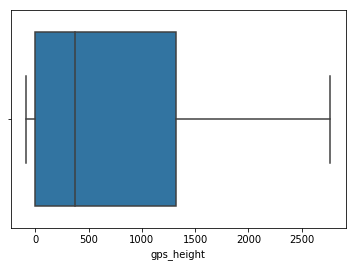

In [20]:
# Again, most values are zero, but so is sea level!
sns.boxplot(x=df.gps_height)

In [21]:
# I suppose if the well is underground than the gps reading would be negative
gps = df.gps_height[df['gps_height'] < 0]
gps.describe()

count    1484.000000
mean      -20.025606
std        12.180454
min       -90.000000
25%       -28.000000
50%       -18.000000
75%       -11.000000
max        -1.000000
Name: gps_height, dtype: float64

In [23]:
# Decided to get rid of all rows with negative gps_height 
df = df[df['gps_height'] >= 0]
df.describe()

,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group,"tsh_(1, 9001]"
count,57643.000000,57643.000000,5.764300e+04,57643.000000,57643.000000,57643.000000,57643.000000,57643.000000,57643.000000,57643.000000
mean,684.553805,33.953825,-5.654338e+00,0.469268,14.820256,5.387037,177.687247,1288.871346,0.690231,0.292941
std,692.843000,6.555084,2.953170e+00,12.345472,16.619158,8.979684,472.863191,955.226485,0.601468,0.455116
min,0.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.045499,-8.535650e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,408.000000,34.827300,-4.911868e+00,0.000000,12.000000,3.000000,20.000000,1985.000000,1.000000,0.000000
75%,1329.000000,37.036182,-3.315421e+00,0.000000,17.000000,5.000000,210.000000,2004.000000,1.000000,1.000000
max,2770.000000,40.283599,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000,1.000000


In [25]:
# Look for three standard deviations above the mean
gps_height_std = df.gps_height.mean() + df.gps_height.std()*3
# Count how many rows are outliers
print("Number of outliers:", df.gps_height[df['gps_height'] > gps_height_std].count())
# Remove outliers from the data
df = df[df['gps_height'] < gps_height_std]

Number of outliers: 1


Feature: 'longitude'

In [23]:
print('Data less than zero:', df.longitude[df['longitude'] <= 0].count())
print('Percent of total:', df.longitude[df['longitude'] <= 0].count()/len(df))

Data less than zero: 1777
Percent of total: 0.03082768072445917


In [26]:
# Let's get rid of the zeros
df = df[df.longitude > 0]
df.longitude.describe()

count    55865.000000
mean        35.033824
std          2.549193
min         29.607122
25%         33.225435
50%         34.918657
75%         37.090302
max         40.283599
Name: longitude, dtype: float64

Feature: 'latitude'

In [27]:
# 'latitude' seems pretty good.
# Lots of of negatives but Tanzania is east of the meridian!

Text(0.5, 1.0, 'Tanzanian Waterpoints')

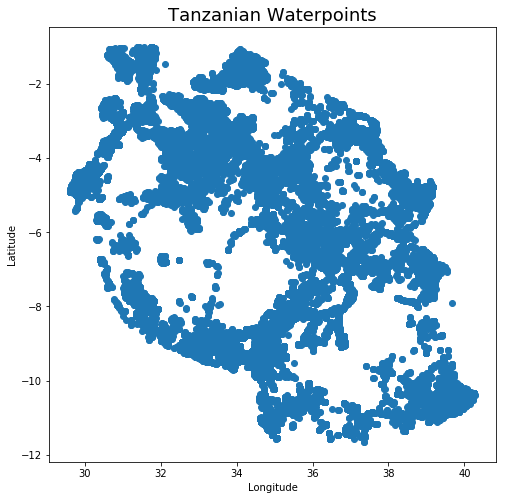

In [28]:
# Look at where waterpoints are located in Tanzania
plt.figure(figsize=(8,8))
plt.scatter(df['longitude'], df['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Tanzanian Waterpoints", fontsize=18)

In [29]:
# Use folium to view a map of Tanzania.
tanzania = folium.Map(location=[-6.17221, 35.73947], zoom_start=5, width=500, 
                      height=500, min_zoom=5, max_zoom=5)
tanzania

Feature: 'num_private' - there is no definition for this column.

In [30]:
# 'num_private' - seems unlikely to be much help to my model.

In [31]:
# Almost all of the data points are zero.
print('Data equal to zero:', df.num_private[df['num_private'] == 0].count())
print('Percent of total:', df.num_private[df['num_private'] == 0].count()/len(df))

Data equal to zero: 55134
Percent of total: 0.9869148840955876


In [32]:
# The majority of 'num_private' are in the 'Pangani' basin.
private = df[df['num_private'] > 0]
private.basin.value_counts()

Pangani                    568
Wami / Ruvu                 56
Rufiji                      35
Lake Nyasa                  26
Ruvuma / Southern Coast     21
Lake Victoria               17
Internal                     8
Name: basin, dtype: int64

In [33]:
# Look for three standard deviations above the mean
num_private_std = df.num_private.mean() + df.num_private.std()*3
# Count how many rows are outliers
print("Number of outliers:", df.num_private[df['num_private'] > num_private_std].count())
# Remove outliers from the data
df = df[df['num_private'] < num_private_std]

Number of outliers: 224


Feature: 'region_code'

In [34]:
# 27 different region codes - according to Google there should be 30 ?
df.region_code.unique()

array([11, 20, 21, 90, 18,  4, 17, 14, 60, 10,  3, 15, 19, 16, 80,  1,  6,
        2, 12, 13,  5,  7, 99, 24,  9,  8, 40])

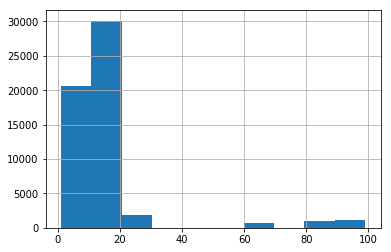

In [35]:
# Visualize the region data
df.region_code.hist()

In [37]:
# Look for three standard deviations above the mean
region_code_std = df.region_code.mean() + df.region_code.std()*3
# Count how many rows are outliers
print("Number of outliers:", df.region_code[df['region_code'] > region_code_std].count())
# Remove outliers from the data
df = df[df['region_code'] < region_code_std]

Number of outliers: 2251


In [38]:
# Guess I'm just going to leave it as continuous data for now.

Feature: 'district_code'

In [39]:
# According to Wikipedia there are 169 different districts in Tanzania
df.district_code.unique()

array([ 5,  2,  4,  1,  8,  3,  6, 43,  7, 30, 33, 53,  0, 80, 60])

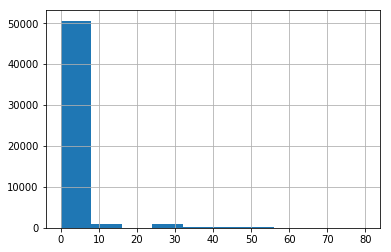

In [40]:
df.district_code.hist()

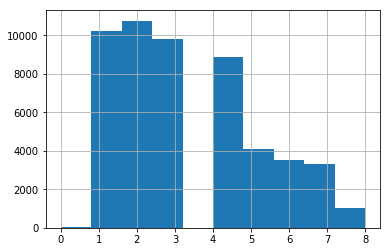

In [41]:
# The majority of data is in the districts below district 10
districts = df[df.district_code <= 10]
districts.district_code.hist()

In [43]:
# Look for three standard deviations above the mean
district_code_std = df.district_code.mean() + df.district_code.std()*3
# Count how many rows are outliers
print("Number of outliers:", df.district_code[df['district_code'] > district_code_std].count())
# Remove outliers from the data
df = df[df['district_code'] < district_code_std]

Number of outliers: 1737


Feature: 'population'

In [44]:
# About 30% of the data points are zero.
print('Data equal to zero:', df.population[df['population'] == 0].count())
print('Percent of total:', df.population[df['population'] == 0].count()/len(df))

Data equal to zero: 18854
Percent of total: 0.365012680773624


In [45]:
# The total population is about 17% of the Tanzanian population
df.population.sum()

8932736

In [46]:
# Thinking about using the mean to fill in the zeros
df.population.mean()

172.93740925018875

In [48]:
# But the median seems really low
df.population.median()

25.0

In [49]:
# Replace the zeros with the median
df.population.replace(0,df.population.median(axis=0),inplace=True)
df.population.describe()

count    51653.000000
mean       182.062726
std        445.133149
min          1.000000
25%         25.000000
50%         25.000000
75%        204.000000
max      30500.000000
Name: population, dtype: float64

In [51]:
# Look for three standard deviations above the mean
population_std = df.population.mean() + df.population.std()*3
print(population_std)
# Count how many rows are outliers
print(df.population[df['population'] > population_std].count())
# Remove outliers from the data
df = df[df['population'] < population_std]

1517.4621736762758
578


Feature: 'construction_year'

In [52]:
# Lots of zeros entered for the contruction year
print('Data equal to zero:', df.construction_year[df['construction_year'] == 0
                                                 ].count())
print('Percent of total:', df.construction_year[df['construction_year'] == 0
                                               ].count()/len(df))

Data equal to zero: 17863
Percent of total: 0.3497405775819873


In [53]:
# The mean construction year without the zeros!
year = df[df['construction_year'] != 0]
print(year['construction_year'].describe())

count    33212.000000
mean      1996.689811
std         12.439892
min       1960.000000
25%       1988.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64


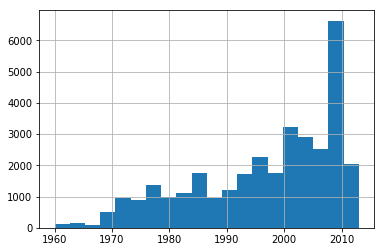

In [54]:
# Trying to get a sense of the average age of the waterpoints 
year.construction_year.hist(bins=20)

In [55]:
# Number of waterpoints below the mean construction year
year.construction_year[year.construction_year < 1996].count()

12773

In [57]:
# Create bins for 'year' based on the values observed. 3 values will result in 2 bins
bins_construct = [1960, 1987, 2000, 2014]
year_bins = pd.cut(year['construction_year'], bins_construct)
year_bins = year_bins.cat.as_ordered()

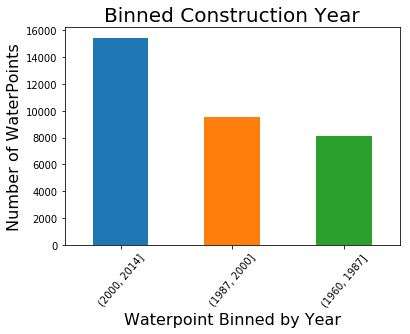

In [58]:
# Bar graph showing known construction years - binned by approximate quartile
year_bins.value_counts().plot(kind='bar')
plt.xlabel('Waterpoint Binned by Year', fontsize=16)
plt.ylabel('Number of WaterPoints', fontsize=16)
plt.title("Binned Construction Year", fontsize=20)
plt.xticks(rotation=50)
plt.show()

In [59]:
# Create bins for 'construction-year based on the values observed. 3 values will result in 2 bins
bins_years = [-1, 1960, 1987, 2000, 2014]
const_year_bins = pd.cut(df['construction_year'], bins_years)
const_year_bins = const_year_bins.cat.as_ordered()

sqft_basement_dummy = pd.get_dummies(const_year_bins, prefix="year", 
                                     drop_first=True)
df = df.drop(["construction_year"], axis=1)
df = pd.concat([df, sqft_basement_dummy], axis=1)

In [60]:
# Confirm the binned years
const_year_bins.head()

0    (1987, 2000]
1    (2000, 2014]
2    (2000, 2014]
4      (-1, 1960]
5    (2000, 2014]
Name: construction_year, dtype: category
Categories (4, interval[int64]): [(-1, 1960] < (1960, 1987] < (1987, 2000] < (2000, 2014]]

In [61]:
# Look at number of waterpoints in each bin
const_year_bins.value_counts()

(-1, 1960]      17952
(2000, 2014]    15450
(1987, 2000]     9543
(1960, 1987]     8130
Name: construction_year, dtype: int64

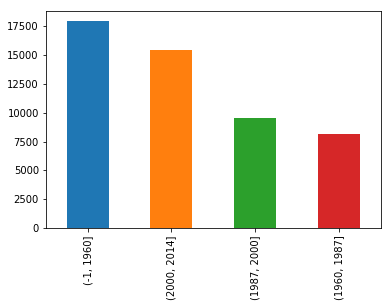

In [62]:
# Visualization of construction year bins with zeros included
const_year_bins.value_counts().plot(kind='bar')

In [63]:
# Confirm bins in dataset
df.describe()

,gps_height,longitude,latitude,num_private,region_code,district_code,population,status_group,"tsh_(1, 9001]","year_(1960, 1987]","year_(1987, 2000]","year_(2000, 2014]"
count,51075.000000,51075.000000,51075.000000,51075.000000,51075.000000,51075.000000,51075.000000,51075.000000,51075.000000,51075.000000,51075.000000,51075.000000
mean,733.840470,34.842112,-5.685787,0.097993,10.879648,3.290866,148.346823,0.693059,0.296270,0.159178,0.186843,0.302496
std,700.752621,2.387656,2.735924,1.377509,6.060029,1.887852,222.857399,0.593874,0.456616,0.365845,0.389789,0.459343
min,0.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.169067,-8.340612,0.000000,5.000000,2.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,654.000000,34.780019,-4.902211,0.000000,11.000000,3.000000,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1364.000000,36.858891,-3.350677,0.000000,16.000000,4.000000,200.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,2628.000000,40.201750,-0.998464,38.000000,21.000000,8.000000,1510.000000,2.000000,1.000000,1.000000,1.000000,1.000000


## Clean the Categorical features

### Group (or delete) unique values to simplify categorical

In [64]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
# Check for missing data - still a lot!
df.isnull().sum()

date_recorded                0
funder                    3451
gps_height                   0
installer                 3460
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2697
recorded_by                  0
scheme_management         3076
scheme_name              22883
permit                    2992
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source  

Feature: 'date_recorded'

In [66]:
# Seems like an unimportant feature with a whole year of unique values
df.date_recorded.describe()

count          51075
unique           352
top       2011-03-15
freq             569
Name: date_recorded, dtype: object

In [67]:
# This is the before
df.date_recorded.head()

0    2011-03-14
1    2013-03-06
2    2013-02-25
4    2011-07-13
5    2011-03-13
Name: date_recorded, dtype: object

In [68]:
# Change dates to datetime
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['date_recorded'] = df['date_recorded'].map(dt.datetime.toordinal)

In [69]:
# This is the after - I hope this doesn't cause an error!
df.date_recorded.head()

0    734210
1    734933
2    734924
4    734331
5    734209
Name: date_recorded, dtype: int64

Feature: 'funder'

In [70]:
# Lots of unique items
df.funder.describe()

count                      47624
unique                      1598
top       Government Of Tanzania
freq                        8187
Name: funder, dtype: object

In [71]:
# Lots of unknown values
df.funder.isna().sum()

3451

In [72]:
# The 'funder' feature will be dropped
df = df.drop(columns="funder", axis=1)

Feature: 'installer'

In [73]:
# Should be an important feature - in my opinion
df.installer.describe()

count     47615
unique     1806
top         DWE
freq      15256
Name: installer, dtype: object

In [74]:
# Lots of unknown values
df.installer.isna().sum()

3460

In [75]:
# 'installer' feature will be dropped - too many unique values
df = df.drop(columns="installer", axis=1)

Feature: 'wpt_name'

In [76]:
# Even with any duplicated names all the rows should be unique
df.wpt_name.describe()

count     51075
unique    32677
top        none
freq       3427
Name: wpt_name, dtype: object

In [77]:
# 'wpt_name' feature will be dropped - irrelevant and too many unique
df = df.drop(columns="wpt_name", axis=1)

Feature: 'basin'

In [78]:
# Nine unique basins in Tanzania
df.basin.describe()

count       51075
unique          9
top       Pangani
freq         8469
Name: basin, dtype: object

In [79]:
# Here are the basins
df.basin.value_counts()

Pangani                    8469
Lake Victoria              7765
Internal                   7352
Rufiji                     7110
Lake Tanganyika            6163
Lake Nyasa                 5018
Wami / Ruvu                4915
Lake Rukwa                 2408
Ruvuma / Southern Coast    1875
Name: basin, dtype: int64

In [80]:
# I viewed this map of the nine different waterbasin regions.
from IPython.display import Image
from IPython.core.display import HTML 
basin_url = ("https://www.researchgate.net/publication/312373453/figure/fig"+
             "1/AS:471438105812994@1489411011502/Map-of-the-nine-River-Basin-"
             +"Offices-in-Tanzania.png")
Image(url=basin_url, width=500, height=400)

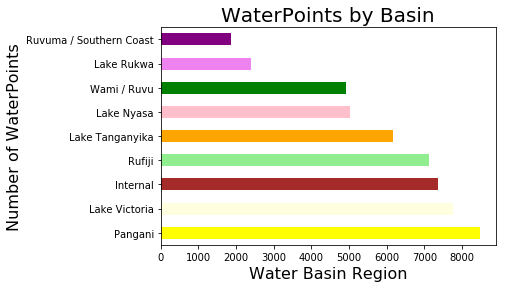

In [81]:
# I also want to see how they look here (I tried to match the colors above).
df.basin.value_counts().plot(kind='barh', color=tuple(["yellow","lightyellow","brown","lightgreen","orange","pink","g","violet","purple"]))
plt.xlabel('Water Basin Region', fontsize=16)
plt.ylabel('Number of WaterPoints', fontsize=16)
plt.title("WaterPoints by Basin", fontsize=20)
plt.show()

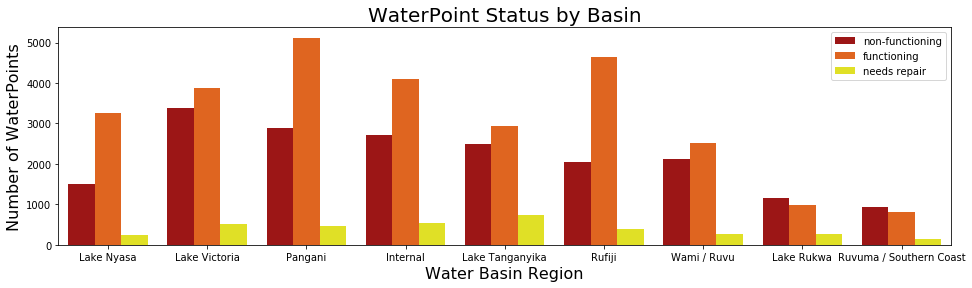

In [82]:
# This bar graph shows the comparison of waterpoint status and basin
plt.figure(figsize=(16,4))
ax = sns.countplot(x="basin", hue='status_group', data=df, palette='hot')
plt.xlabel('Water Basin Region', fontsize=16)
plt.ylabel('Number of WaterPoints', fontsize=16)
plt.title("WaterPoint Status by Basin", fontsize=20)
labels = ['non-functioning', 'functioning', 'needs repair']
plt.legend(labels)
plt.show()

In [83]:
# I plan to bin 'basin' later

Feature: 'subvillage'

In [84]:
# Too many unique items to bin
df.subvillage.describe()

count       50704
unique      16803
top       Majengo
freq          421
Name: subvillage, dtype: object

In [85]:
# Some unknown values
df.subvillage.isna().sum()

371

In [86]:
# The 'subvillage' feature will be dropped
df = df.drop(columns="subvillage", axis=1)

Feature: 'region'

In [87]:
# We already have 'region_code' and there are too many unique items
df.region.describe()

count      51075
unique        21
top       Iringa
freq        5248
Name: region, dtype: object

In [88]:
# The 'region' feature will be dropped
df = df.drop(columns='region', axis=1)

Feature: 'lga'

In [89]:
# Another location feature
df.lga.describe()

count      51075
unique       113
top       Njombe
freq        2477
Name: lga, dtype: object

In [90]:
# Tanzania-specific geographic indicator of where pump is located
df.lga.head()

0       Ludewa
1    Serengeti
2    Simanjiro
4      Karagwe
5       Mkinga
Name: lga, dtype: object

In [91]:
# The 'lga' feature will be dropped - irrelevant and too many unique
df = df.drop(columns="lga", axis=1)

Feature: 'ward'

In [92]:
# Name of Tanzanian geographic ward where pump is located
df.ward.describe()

count     51075
unique     1823
top       Igosi
freq        307
Name: ward, dtype: object

In [93]:
# The 'ward' feature will be dropped for similar reasons
df = df.drop(columns="ward", axis=1)

Feature: 'public_meeting'

In [94]:
# True/False indicator of public or not
df.public_meeting.describe()

count     48378
unique        2
top        True
freq      44130
Name: public_meeting, dtype: object

In [95]:
# Column is missing some information
df.public_meeting.isna().sum()

2697

In [96]:
# Most of the values are True - which I assume means public
df.public_meeting.value_counts()

True     44130
False     4248
Name: public_meeting, dtype: int64

In [97]:
# Almost 10% is NaN
df.public_meeting.head()

0    True
1     NaN
2    True
4    True
5    True
Name: public_meeting, dtype: object

In [98]:
# Fill NaN's with the mean value of True
df['public_meeting'].fillna(True, inplace = True)
df.public_meeting.head()

0    True
1    True
2    True
4    True
5    True
Name: public_meeting, dtype: bool

Feature: 'recorded_by'

In [99]:
# Everything was recorded by the same person!
df.recorded_by.describe()

count                       51075
unique                          1
top       GeoData Consultants Ltd
freq                        51075
Name: recorded_by, dtype: object

In [100]:
# The 'recorded_by' feature will be dropped - not useful
df = df.drop(columns='recorded_by', axis=1)

Feature: 'scheme_management'

In [101]:
# Type of the organization responsible for management of pump
df.scheme_management.describe()

count     47999
unique       11
top         VWC
freq      31693
Name: scheme_management, dtype: object

In [102]:
# Too many types to bin
df.scheme_management.value_counts()

VWC                 31693
WUG                  4063
Water authority      3004
WUA                  2757
Water Board          2704
Parastatal           1474
Company               841
Private operator      726
Other                 666
Trust                  45
SWC                    26
Name: scheme_management, dtype: int64

In [103]:
# The 'scheme_management' feature will be dropped
df = df.drop(columns='scheme_management', axis=1)

Feature: 'scheme_name'

In [104]:
df.scheme_name.describe()

count     28192
unique     2348
top           K
freq        680
Name: scheme_name, dtype: object

In [106]:
# Column is missing almost half of the information
df.scheme_name.isna().sum()

22883

In [107]:
# The 'scheme_name' feature will be dropped
df = df.drop(columns='scheme_name', axis=1)

Feature: 'permit'

In [108]:
# True or False values
df.permit.describe()

count     48083
unique        2
top        True
freq      34553
Name: permit, dtype: object

In [109]:
# Most of the values are True - which I assume means it has a permit
df.permit.value_counts()

True     34553
False    13530
Name: permit, dtype: int64

In [110]:
# Column is missing some information
df.permit.isna().sum()

2992

In [111]:
# Fill NaN's with the 'False' - either you have a permit or you don't!
df['permit'].fillna(False, inplace = True)

In [112]:
# No more missing information other than possible zeros!
df.isnull().sum()

date_recorded            0
gps_height               0
longitude                0
latitude                 0
num_private              0
basin                    0
region_code              0
district_code            0
population               0
public_meeting           0
permit                   0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
status_group             0
tsh_(1, 9001]            0
year_(1960, 1987]        0
year_(1987, 2000]        0
year_(2000, 2014]        0
dtype: int64

Feature: 'extraction_type' & 'extraction_type_group'

In [113]:
# Both features have overlapping and redundant items
df.extraction_type.describe()

count       51075
unique         18
top       gravity
freq        24896
Name: extraction_type, dtype: object

In [114]:
# The 'extraction_type' & extraction_type_group' features will be dropped
df = df.drop(columns=['extraction_type', 'extraction_type_group'], axis=1)

Feature: 'extraction_type_class'

In [115]:
# Aggregation of extraction_type_group categories
df.extraction_type_class.describe()

count       51075
unique          7
top       gravity
freq        24896
Name: extraction_type_class, dtype: object

In [116]:
# Seven different groups to bin - seems like a lot
df.extraction_type_class.value_counts()

gravity         24896
handpump        13501
other            5136
submersible      4722
motorpump        2299
rope pump         417
wind-powered      104
Name: extraction_type_class, dtype: int64

In [117]:
# Group 'others' together
df.extraction_type_class = df.extraction_type_class.replace(to_replace = 
                                                            ['rope pump', 
                                                             'wind-powered'], 
                                                            value = 'other')
df.extraction_type_class.value_counts()

gravity        24896
handpump       13501
other           5657
submersible     4722
motorpump       2299
Name: extraction_type_class, dtype: int64

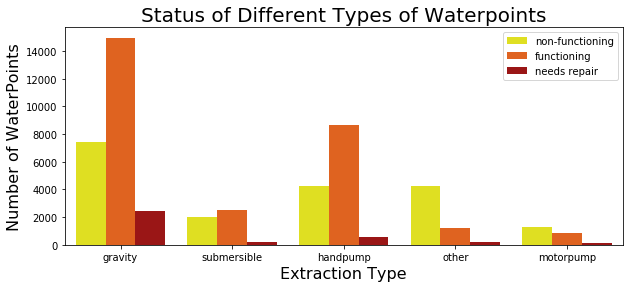

In [118]:
# This bar graph shows the comparison of waterpoint status and basin
plt.figure(figsize=(10,4))
ax = sns.countplot(x="extraction_type_class", hue='status_group', data=df, palette='hot_r')
plt.xlabel('Extraction Type', fontsize=16)
plt.ylabel('Number of WaterPoints', fontsize=16)
plt.title("Status of Different Types of Waterpoints", fontsize=20)
labels = ['non-functioning', 'functioning', 'needs repair']
plt.legend(labels)
plt.show()


In [119]:
# Looks like 'other' and 'motorpump' have the most non-functional
# While 'gravity' and 'handpump' are the most functioning

Feature: 'management'

In [120]:
# Name of method employed for management of a given pump
df.management.describe()

count     51075
unique       12
top         vwc
freq      34719
Name: management, dtype: object

In [121]:
# The 'management' feature will be dropped - too many unique
df = df.drop(columns='management', axis=1)

Feature: 'management_group'

In [122]:
# Aggregation of management categories - 5 in all
df.management_group.value_counts()

user-group    45345
commercial     2946
parastatal     1525
other           774
unknown         485
Name: management_group, dtype: int64

In [123]:
# Group 'unknowns' and 'other' together to reduce bins
df.management_group = df.management_group.replace(to_replace = ['unknown', 
                                                'commercial', 'parastatal'],
                                                value = 'other')
df.management_group.value_counts()

user-group    45345
other          5730
Name: management_group, dtype: int64

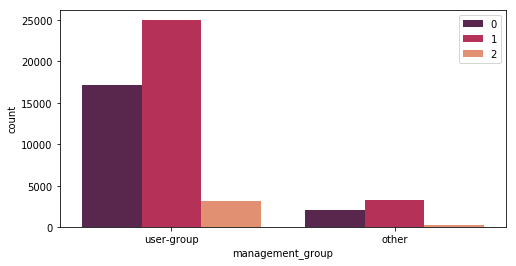

In [124]:
# This bar graph shows the comparison of user_groups - not much difference
plt.figure(figsize=(8,4))
ax = sns.countplot(x="management_group", hue='status_group', data=df, palette='rocket')
plt.legend()

Feature: 'payment'

In [125]:
# Categorical indicator of payment method required of pump users
df.payment.value_counts()

never pay                21397
pay monthly               7861
unknown                   6873
pay per bucket            6827
pay when scheme fails     3792
pay annually              3480
other                      845
Name: payment, dtype: int64

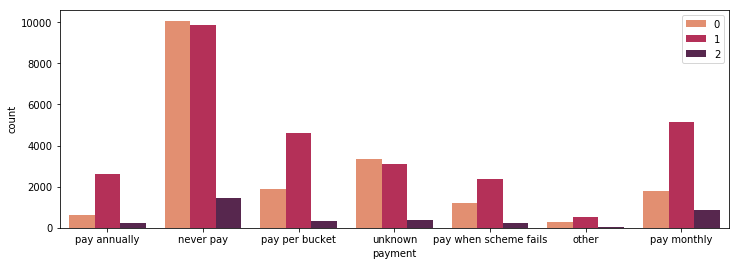

In [126]:
# This bar graph shows the comparison of payments
plt.figure(figsize=(12,4))
ax = sns.countplot(x="payment", hue='status_group', data=df, palette='rocket_r')
plt.legend()

In [127]:
# 'never pay' and 'unknown' clearly are the worse, which makes sense

In [128]:
# group 'unknowns' and 'other' together to reduce bins
df.payment = df.payment.replace(to_replace = ['other'],
                                              value = 'unknown')
df.payment.value_counts()

never pay                21397
pay monthly               7861
unknown                   7718
pay per bucket            6827
pay when scheme fails     3792
pay annually              3480
Name: payment, dtype: int64

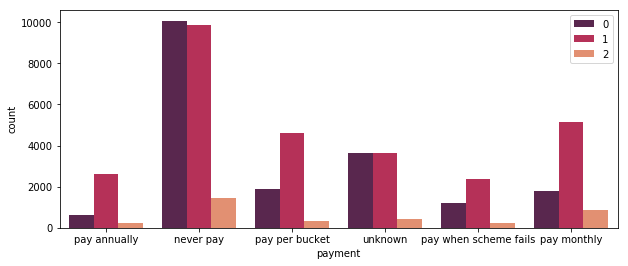

In [129]:
# Visualize functioning and non-functioning
plt.figure(figsize=(10,4))
ax = sns.countplot(x="payment", hue='status_group', data=df, palette='rocket')
plt.legend()

Feature: 'payment_type'

In [130]:
# Appears to be a duplicate of payment categories
df.payment_type.value_counts()

never pay     21397
monthly        7861
unknown        6873
per bucket     6827
on failure     3792
annually       3480
other           845
Name: payment_type, dtype: int64

In [131]:
# The 'payment_type' feature will be dropped as redundant
df = df.drop(columns='payment_type', axis=1)

Feature: 'quality_group'

In [132]:
# Aggregation of water_quality categories - 6 unique
df.quality_group.describe()

count     51075
unique        6
top        good
freq      44306
Name: quality_group, dtype: object

In [133]:
# A very small percentage are less than 'drinkable' water type
df.quality_group.value_counts()

good        44306
salty        3850
unknown      1550
milky         756
colored       418
fluoride      195
Name: quality_group, dtype: int64

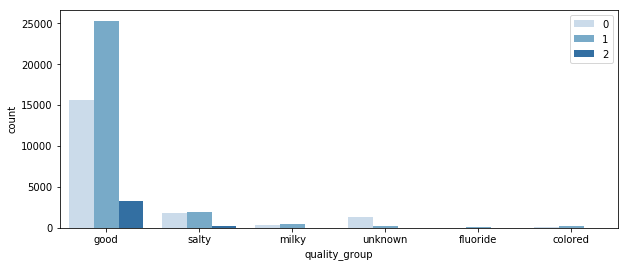

In [134]:
# Doesn't look like qualities are effecting much
plt.figure(figsize=(10,4))
ax = sns.countplot(x="quality_group", hue='status_group', data=df, palette='Blues')
plt.legend()

In [135]:
# The 'quality_group' feature will be dropped as redundant
df = df.drop(columns='quality_group', axis=1)

Feature: 'water_quality'

In [136]:
# Same as 'quality-group'
df.water_quality.describe()

count     51075
unique        8
top        soft
freq      44306
Name: water_quality, dtype: object

In [137]:
# Lots of categories not doing much for the model
df.water_quality.value_counts()

soft                  44306
salty                  3647
unknown                1550
milky                   756
coloured                418
salty abandoned         203
fluoride                184
fluoride abandoned       11
Name: water_quality, dtype: int64

In [138]:
# Group all non-soft water as other
df.water_quality = df.water_quality.replace(to_replace = ['salty', 'milky', 'unknown', 
                                            'fluoride', 'coloured','salty abandoned', 
                                            'fluoride abandoned'], 
                                                value = 'other')
df.water_quality.value_counts()

soft     44306
other     6769
Name: water_quality, dtype: int64

Feature: 'quantity'

In [139]:
# Categorical indicator of water quantity produced by pump
df.quantity.value_counts()

enough          28433
insufficient    13292
dry              5040
seasonal         3615
unknown           695
Name: quantity, dtype: int64

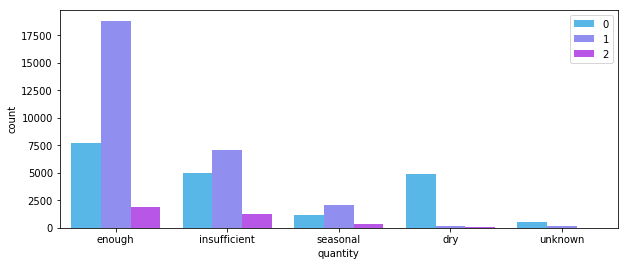

In [140]:
# Doesn't look like quantities are effecting much - other than 'dry'
plt.figure(figsize=(10,4))
ax = sns.countplot(x="quantity", hue='status_group', data=df, palette='cool')
plt.legend()

In [141]:
# Group 'unknowns'
df.quantity = df.quantity.replace(to_replace = ['unknown', 'dry', 
                                                        'seasonal'], 
                                                value = 'insufficient')
df.quantity.value_counts()

enough          28433
insufficient    22642
Name: quantity, dtype: int64

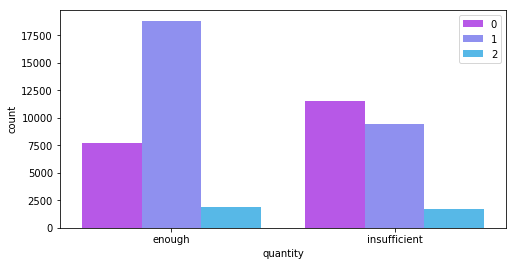

In [142]:
# Quantities
plt.figure(figsize=(8,4))
ax = sns.countplot(x="quantity", hue='status_group', data=df, palette='cool_r')
plt.legend()

In [143]:
# Dry wells and insufficient waterpoints seem to be more non-functioning

Feature: 'source' and 'source_type'

In [144]:
# Type of source and type of the water for a given pump
df.source.describe()

count      51075
unique        10
top       spring
freq       15750
Name: source, dtype: object

In [145]:
# These features will be dropped as redundant
df = df.drop(columns=['source', 'source_type'], axis=1)

Feature: 'source_class'

In [146]:
# Aggregation of sources
df.source_class.describe()

count           51075
unique              3
top       groundwater
freq            38833
Name: source_class, dtype: object

In [147]:
# Most of the water comes from groundwater
df.source_class.value_counts()

groundwater    38833
surface        11992
unknown          250
Name: source_class, dtype: int64

In [148]:
# Group 'unknowns' and 'groundwater' together
df.source_class = df.source_class.replace(to_replace = 'unknown', 
                                                value = 'groundwater')
df.source_class.value_counts()

groundwater    39083
surface        11992
Name: source_class, dtype: int64

Feature: 'waterpoint_type_group'

In [149]:
# Similar to waterpoint_type
df.waterpoint_type_group.describe()

count                  51075
unique                     6
top       communal standpipe
freq                   30906
Name: waterpoint_type_group, dtype: object

In [150]:
# The 'waterpoint_type_group' will be dropped as redundant
df = df.drop(columns='waterpoint_type_group', axis=1)

Feature: 'waterpoint_type'

In [151]:
# The type of pump installed at a well site
df.waterpoint_type.value_counts()

communal standpipe             26038
hand pump                      14474
communal standpipe multiple     4868
other                           4831
improved spring                  755
cattle trough                    103
dam                                6
Name: waterpoint_type, dtype: int64

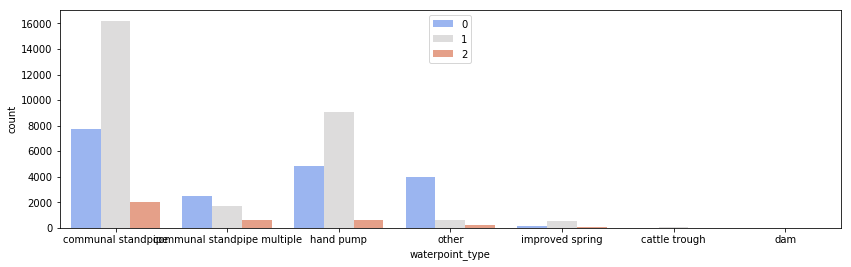

In [152]:
# Looking at types of pumps
plt.figure(figsize=(14,4))
ax = sns.countplot(x="waterpoint_type", hue='status_group', data=df, palette='coolwarm')
plt.legend()

In [153]:
# Group all 'standpipes'
df.waterpoint_type = df.waterpoint_type.replace(to_replace = 'communal standpipe multiple', 
                                                value = 'communal standpipe')
df.waterpoint_type.value_counts()

communal standpipe    30906
hand pump             14474
other                  4831
improved spring         755
cattle trough           103
dam                       6
Name: waterpoint_type, dtype: int64

In [154]:
# Group all 'other'
df.waterpoint_type = df.waterpoint_type.replace(to_replace = ['improved spring',
                                                   'cattle trough', 'dam'], 
                                                    value = 'other')
df.waterpoint_type.value_counts()

communal standpipe    30906
hand pump             14474
other                  5695
Name: waterpoint_type, dtype: int64

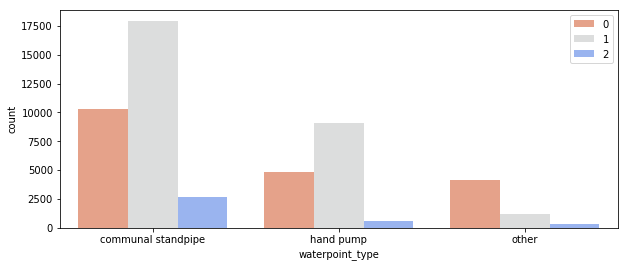

In [155]:
# Standpipes and handpumps visual
plt.figure(figsize=(10,4))
ax = sns.countplot(x="waterpoint_type", hue='status_group', data=df, palette='coolwarm_r')
plt.legend()

In [156]:
# One last look at df
df.head()

,date_recorded,gps_height,longitude,latitude,num_private,basin,region_code,district_code,population,public_meeting,...,water_quality,quantity,quantity_group,source_class,waterpoint_type,status_group,"tsh_(1, 9001]","year_(1960, 1987]","year_(1987, 2000]","year_(2000, 2014]"
0,734210,1390,34.938093,-9.856322,0,Lake Nyasa,11,5,109,True,...,soft,enough,enough,groundwater,communal standpipe,1,1,0,1,0
1,734933,1399,34.698766,-2.147466,0,Lake Victoria,20,2,280,True,...,soft,insufficient,insufficient,surface,communal standpipe,1,0,0,0,1
2,734924,686,37.460664,-3.821329,0,Pangani,21,4,250,True,...,soft,enough,enough,surface,communal standpipe,1,1,0,0,1
4,734331,0,31.130847,-1.825359,0,Lake Victoria,18,1,25,True,...,soft,insufficient,seasonal,surface,communal standpipe,1,0,0,0,0
5,734209,0,39.172796,-4.765587,0,Pangani,4,8,1,True,...,other,enough,enough,groundwater,communal standpipe,1,1,0,0,1


## One Hot Encoding for Categorical

In [157]:
# These are the object columns that need to be binned.
col_to_dummies = ['basin', 'public_meeting', 'permit',
       'extraction_type_class', 'management_group', 'payment', 'water_quality',
       'quantity', 'source_class', 'waterpoint_type']

In [158]:
# get_dummy variables and drop first (it is going to double my column count)
df = pd.get_dummies(df, drop_first=True)

In [159]:
# new df head - 42 columns now!
df.head()

,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,permit,...,payment_unknown,water_quality_soft,quantity_insufficient,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_class_surface,waterpoint_type_hand pump,waterpoint_type_other
0,734210,1390,34.938093,-9.856322,0,11,5,109,True,False,...,0,1,0,1,0,0,0,0,0,0
1,734933,1399,34.698766,-2.147466,0,20,2,280,True,True,...,0,1,1,0,1,0,0,1,0,0
2,734924,686,37.460664,-3.821329,0,21,4,250,True,True,...,0,1,0,1,0,0,0,1,0,0
4,734331,0,31.130847,-1.825359,0,18,1,25,True,True,...,0,1,1,0,0,1,0,1,0,0
5,734209,0,39.172796,-4.765587,0,4,8,1,True,True,...,0,0,0,1,0,0,0,0,0,0


In [160]:
# Double check that I have all the ones I want
df.columns

Index(['date_recorded', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'public_meeting',
       'permit', 'status_group', 'tsh_(1, 9001]', 'year_(1960, 1987]',
       'year_(1987, 2000]', 'year_(2000, 2014]', 'basin_Lake Nyasa',
       'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria',
       'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast',
       'basin_Wami / Ruvu', 'extraction_type_class_handpump',
       'extraction_type_class_motorpump', 'extraction_type_class_other',
       'extraction_type_class_submersible', 'management_group_user-group',
       'payment_pay annually', 'payment_pay monthly', 'payment_pay per bucket',
       'payment_pay when scheme fails', 'payment_unknown',
       'water_quality_soft', 'quantity_insufficient', 'quantity_group_enough',
       'quantity_group_insufficient', 'quantity_group_seasonal',
       'quantity_group_unknown', 'source_class_surface',
       'water

# Models

In [161]:
# I plan to build at least three models: (Logarithmic, Random Forest, and XGBoost)

## Train Test Split

In [162]:
# Rename column names to simplify (and for XGBoost)
df.rename(columns={'tsh_(1, 9001]':'amount',
                    'year_(1960, 1987]':'old',
                    'year_(1987, 2000]':'semi-old',
                    'year_(2000, 2014]': 'new'}, 
                    inplace=True)

In [163]:
# Three classes of independent target variable
y = df.status_group

In [164]:
# Drop target and set the dependent values variables 
X = df.drop('status_group', axis=1) 

In [165]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### Log Model

In [166]:
# Log model
log_clf = LogisticRegression(random_state=123, multi_class='multinomial', solver='newton-cg')
log_model = log_clf.fit(X_train, y_train)

log_training_preds = log_clf.predict(X_train)
log_training_accuracy = accuracy_score(y_train, log_training_preds)

log_val_preds = log_clf.predict(X_test) # y_hat
log_val_accuracy = accuracy_score(y_test, log_val_preds)

print("Log Training Accuracy: {:.4}%".format(log_training_accuracy * 100))
print("Log Validation accuracy: {:.4}%".format(log_val_accuracy * 100))

Log Training Accuracy: 71.82%
Log Validation accuracy: 71.94%


In [167]:
# Classification report showing all three classes, precision and recall
print(classification_report(y_test, log_val_preds))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66      4809
           1       0.70      0.91      0.79      7062
           2       0.42      0.02      0.03       898

    accuracy                           0.72     12769
   macro avg       0.63      0.50      0.49     12769
weighted avg       0.71      0.72      0.69     12769



In [168]:
# Confusion matrix 
log_matrix = confusion_matrix(y_test, log_val_preds)
print('Confusion Matrix:\n', log_matrix)

Confusion Matrix:
 [[2761 2040    8]
 [ 640 6411   11]
 [ 147  737   14]]


In [169]:
# Not the best model, but a good start

### Forest Model

In [188]:
# Forest Model
# Models with criterion='gini' and 'entropy' were about the same.
forest_clf = RandomForestClassifier()
forest_model = forest_clf.fit(X_train, y_train)

forest_training_preds = forest_clf.predict(X_train)
forest_training_accuracy = accuracy_score(y_train, forest_training_preds)

forest_val_preds = forest_clf.predict(X_test) # y_hat
forest_val_accuracy = accuracy_score(y_test, forest_val_preds)

print("Forest Training Accuracy: {:.4}%".format(forest_training_accuracy * 100))
print("Forest Validation accuracy: {:.4}%".format(forest_val_accuracy * 100))

Forest Training Accuracy: 98.46%
Forest Validation accuracy: 78.58%


In [189]:
# Classification report
print(classification_report(y_test, forest_val_preds))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      4809
           1       0.81      0.84      0.83      7062
           2       0.47      0.31      0.38       898

    accuracy                           0.79     12769
   macro avg       0.69      0.65      0.66     12769
weighted avg       0.78      0.79      0.78     12769



In [190]:
# Confusion matrix 
forest_matrix = confusion_matrix(y_test, forest_val_preds)
print('Confusion Matrix:\n', forest_matrix)

Confusion Matrix:
 [[3788  928   93]
 [ 874 5964  224]
 [ 164  452  282]]


In [191]:
# Much better model in the training (perhaps over fitting a bit).
# And better accuracy overall

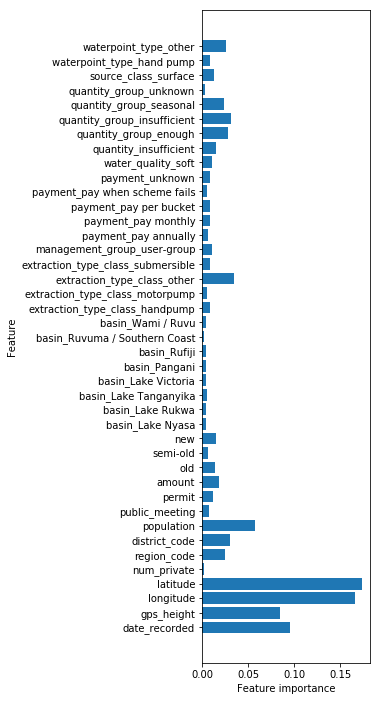

In [192]:
# A look at which features are important from the forest model
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(3,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(forest_clf)

In [175]:
# The latitude and logitude come out on top - not as I would have expected.
# Not sure what date and gps have to do with anything.
# Population makes sense, as does waterpoint_type and insufficient

## Forst Model with GridSearch

In [199]:
# Forst Model with GridSearch parameters
param_grid_2 = {
    'max_depth': [5, 10, 50, None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 5],
    'n_estimators': [10, 25, 100],
}

In [200]:
# GridSearch Classifier
# This time I'm going to try criterion='entropy'
forest_clf = RandomForestClassifier(criterion='entropy')
grid_clf = GridSearchCV(forest_clf, param_grid_2, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds_forest = grid_clf.predict(X_train)
training_accuracy_forest = accuracy_score(y_train, training_preds_forest)

val_preds_forest = grid_clf.predict(X_test)
val_accuracy_forest = accuracy_score(y_test, val_preds_forest)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_forest * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_forest * 100))

Grid Search found the following optimal parameters: 
max_depth: 50
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 100

Training Accuracy: 91.06%
Validation accuracy: 80.38%


In [201]:
# Classification report
print(classification_report(y_test, val_preds_forest))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      4809
           1       0.80      0.90      0.85      7062
           2       0.59      0.28      0.38       898

    accuracy                           0.80     12769
   macro avg       0.74      0.65      0.67     12769
weighted avg       0.80      0.80      0.79     12769



In [202]:
# Confusion matrix
grid_forest_matrix = confusion_matrix(y_test, val_preds_forest)
print('Confusion Matrix:\n', grid_forest_matrix)

Confusion Matrix:
 [[3657 1107   45]
 [ 579 6359  124]
 [ 128  522  248]]


In [ ]:
# This is the best model so far.

### XGBoost

In [203]:
# XGB classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

xgb_training_preds = xgb_clf.predict(X_train)
xgb_training_accuracy = accuracy_score(y_train, xgb_training_preds)

xgb_val_preds = xgb_clf.predict(X_test)
xgb_val_accuracy = accuracy_score(y_test, xgb_val_preds)

print("XGB Training Accuracy: {:.4}%".format(xgb_training_accuracy * 100))
print("XGB Validation accuracy: {:.4}%".format(xgb_val_accuracy * 100))

XGB Training Accuracy: 73.72%
XGB Validation accuracy: 73.87%


In [204]:
# XGB classification report
print(classification_report(y_test, xgb_val_preds))

              precision    recall  f1-score   support

           0       0.82      0.59      0.68      4809
           1       0.71      0.93      0.80      7062
           2       0.59      0.05      0.10       898

    accuracy                           0.74     12769
   macro avg       0.71      0.52      0.53     12769
weighted avg       0.74      0.74      0.71     12769



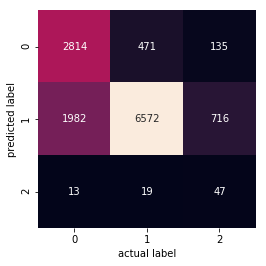

In [205]:
# XGB pretty confusion matrix
xgb_matrix = confusion_matrix(y_test, xgb_val_preds)
sns.heatmap(xgb_matrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('actual label')
plt.ylabel('predicted label');

In [206]:
# Regular confusion matrix - looks similar
xgb_matrix = confusion_matrix(y_test, xgb_val_preds)
print('Confusion Matrix:\n', xgb_matrix)

Confusion Matrix:
 [[2814 1982   13]
 [ 471 6572   19]
 [ 135  716   47]]


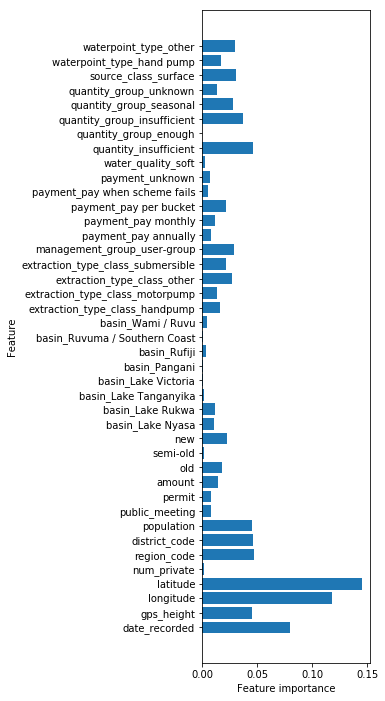

In [207]:
# xgb feature importance
plot_feature_importances(xgb_clf)

In [208]:
# Similar results in terms of performance and feature importance.

### GridSearch with XGBoost

In [209]:
# XGBoost GridSearch parameters grid
param_grid_1 = {
    "learning_rate": [0.1],
    'max_depth': [1, 5, 10],
    'min_child_weight': [0, 1],
    'subsample': [0, .1, .5],
    'n_estimators': [0, 1, 10],
}

In [210]:
# GridSearch Classifier with XGB
grid_clf = GridSearchCV(xgb_clf, param_grid_1, scoring='accuracy', n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds_xgb = grid_clf.predict(X_train)
training_accuracy_xgb = accuracy_score(y_train, training_preds_xgb)
val_preds_xgb = grid_clf.predict(X_test)
val_accuracy_xgb = accuracy_score(y_test, val_preds_xgb)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_xgb * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 10
min_child_weight: 0
n_estimators: 10
subsample: 0.5

Training Accuracy: 80.69%
Validation accuracy: 77.54%


In [211]:
# Classification Report of XGBoost GridSearch
print(classification_report(y_test, val_preds_xgb))

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      4809
           1       0.75      0.93      0.83      7062
           2       0.65      0.18      0.28       898

    accuracy                           0.78     12769
   macro avg       0.75      0.59      0.62     12769
weighted avg       0.78      0.78      0.76     12769



In [212]:
# Confusion Matrix of XGBoost GridSearch
grid_xgb_matrix = confusion_matrix(y_test, val_preds_xgb)
print('Confusion Matrix:\n', grid_xgb_matrix)

Confusion Matrix:
 [[3142 1640   27]
 [ 404 6601   57]
 [ 127  613  158]]


In [213]:
# Not much better than the auto-model.

## A Simpler Model

In [ ]:
# This is a basic model
# I reload the target and values and merge into a new df
# Then I delete missing values
# Delete irrelevant features
# And apply one-hot-encoding
# Then I do the train/test split and run the forest model again

In [221]:
target = pd.read_csv("train_set_labels.csv")

In [222]:
target = target.replace({'status_group': {'functional' : 1, 
                                'non functional' : 0, 
                                'functional needs repair' : 2}})

In [223]:
values = pd.read_csv("train_set_values.csv")

In [224]:
df = pd.concat([values, target], axis=1)

In [225]:
new_df = pd.concat([values, target], axis=1)

In [226]:
new_df = df.dropna(axis = 0)

In [227]:
print("Old data frame length:", len(df), "\nNew data frame length:",  
       len(new_df), "\nNumber of rows with at least 1 NA value: ", 
       (len(df)-len(new_df)))

Old data frame length: 59400 
New data frame length: 27813 
Number of rows with at least 1 NA value:  31587


In [228]:
col_to_delete = ['id','date_recorded', 'recorded_by', 'funder', 'installer',  
                'lga', 'ward', 'region', 'scheme_management', 'wpt_name',
                'scheme_name', 'extraction_type', 'extraction_type_group',
                'management', 'payment_type', 'quality_group', 'source_type',
                'source', 'waterpoint_type_group', 'quantity_group', 'subvillage']
new_df = new_df.drop(col_to_delete, axis=1)

In [229]:
new_df = pd.get_dummies(new_df, drop_first=True)

In [230]:
y2 = new_df.status_group

In [231]:
X2 = new_df.drop('status_group', axis=1)

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.25, 
                                                    random_state=123)

In [ ]:
# After resplitting the train/test, I run a Random Forest model

In [233]:
# Forest Model
forest_clf2 = RandomForestClassifier(criterion = 'entropy')
forest_model2 = forest_clf2.fit(X_train, y_train)

forest_training_preds2 = forest_clf2.predict(X_train)
forest_training_accuracy2 = accuracy_score(y_train, forest_training_preds2)

forest_val_preds2 = forest_clf2.predict(X_test) #y_hat
forest_val_accuracy2 = accuracy_score(y_test, forest_val_preds2)

print("Forest Training Accuracy: {:.4}%".format(forest_training_accuracy2 * 100))
print("Forest Validation Accuracy: {:.4}%".format(forest_val_accuracy2 * 100))

Forest Training Accuracy: 98.62%
Forest Validation Accuracy: 81.29%


In [ ]:
# The accuracy is the highest of all!

In [234]:
print(classification_report(y_test, forest_val_preds2))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2432
           1       0.84      0.87      0.86      4059
           2       0.50      0.32      0.39       463

    accuracy                           0.81      6954
   macro avg       0.72      0.67      0.68      6954
weighted avg       0.81      0.81      0.81      6954



In [235]:
new_forest_matrix = confusion_matrix(y_test, forest_val_preds2)
print('Confusion Matrix:\n', new_forest_matrix)

Confusion Matrix:
 [[1965  428   39]
 [ 412 3538  109]
 [  84  229  150]]


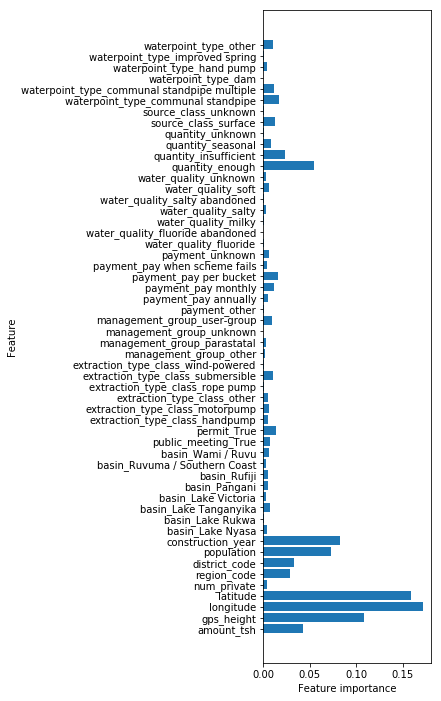

In [236]:
# new forest feature importance
plot_feature_importances(forest_model2)

In [241]:
# XGB classifier again
xgb_clf2 = xgb.XGBClassifier(learning_rate = 0.1,
                            max_depth = 10,
                            min_child_weight = 0,
                            n_estimators = 10,
                            subsample = 0.5)
xgb_clf2.fit(X_train, y_train)

xgb_training_preds2 = xgb_clf2.predict(X_train)
xgb_training_accuracy2 = accuracy_score(y_train, xgb_training_preds2)

xgb_val_preds2 = xgb_clf2.predict(X_test)
xgb_val_accuracy2 = accuracy_score(y_test, xgb_val_preds2)

print("XGB Training Accuracy: {:.4}%".format(xgb_training_accuracy2 * 100))
print("XGB Validation accuracy: {:.4}%".format(xgb_val_accuracy2 * 100))

XGB Training Accuracy: 85.32%
XGB Validation accuracy: 81.03%


In [242]:
# XGB classification report again
print(classification_report(y_test, xgb_val_preds2))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      2432
           1       0.81      0.92      0.86      4059
           2       0.65      0.25      0.36       463

    accuracy                           0.81      6954
   macro avg       0.76      0.63      0.67      6954
weighted avg       0.81      0.81      0.80      6954



In [243]:
# Another good model but the Random Forest seemed better.

# Summary

The best overall model was the simple Random Forest with criterion='entropy' and all rows with missing values deleted. This model was able to predict water-points with 0.8144 accuracy and had similar values for precision and recall.

GridSearch was able to improve my basic XGBBoost model to 0.8103 along with extensive cleaning of the data. The large percentage of categorical data columns, at least a third of which were repetitive or overlapping, made it difficult to sort through and decide on features that were most relevant. As well, the multiple continuous features that contained either a high percentage of zeros or more missing data made many of these features also unusable or irrelevant.

While it might be a waste of time and resources to visit a possibly non-functioning water-point only to find that it was in fact still working - I believe it is better to error on the side of having too many false positives as opposed to letting people go without a safe drinking water source. 


## Conclusions

My research found that payment types of 'monthly', 'annually', and 'per bucket' were the most efficient - which makes sense compared to 'free' or 'unknown' potable water! Obviously, waterpoints with a payment system were less likely to need repair.

'Hand-pumps' and 'standpipes' were the most likely extraction types to remain functional. Therefore, the replacement of any of the broken or non-functioning wells should be converted to a more durable and dependable source if possible.

All models seem to point toward location as a highly valuable aspect of determining water-point status. While certain 'Water Basins' were more likely to have a higher percentage of either non-functioning water sources or water-points in need of repair, there is evidence that this could also be based on the regions' climate, amount of rainfall, population, and economic development.

## Future work

As a way to increase the accuracy of supervised learning models, I would like to see better information on number of people who are using pumps on a daily or weekly basis and number of visits per given period.

Though my highest recommendation for future work would be to focus on the quality and cleanliness of water - as this is certainly one of the most important functions to a healthy community. 

Any data that points to when a water-point was last serviced or replaced as well as a list of issues (i.e. broken handle, no water, power outages) would be beneficial to future models. 

A more regulated collection of information and more precise entry of specific data is needed (water-point age, certain types, number of people using, etc.) in addition to a more standard set of options - such that location, payment, and source could be standardized, thus eliminating much of the missing data.

It might also be helpful to know how to measure the amount of water that is available - the 'amount_tsh' feature seems like it could be very useful but this information would need to be clearly measured as well as the method specifically described in detail. 


